In [1]:
%load_ext Cython

In [2]:
import numpy as np
#cimport numpy as np
import h5py
from MSMRD.trajectories import discretizer
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
%%cython
import numpy as np
cimport numpy as np
from multiprocessing import Pool
cdef extern from "math.h":
    double atan2(double y, double x)
    
cdef double PI = np.pi

cdef class trajDiscretizationCython:
    cdef object centers
    cdef public double innerMSMrad, entryRad, bathRad, bathRadOut, radialIncrementEntry, radialIncrementExit
    cdef public int angularPartitions, entryRings, exitRings, radialPartitions, Ncenters, bathIndex
    def __init__(self, np.ndarray[double, ndim=2] centers):
        self.centers = centers
        self.innerMSMrad = 2.0
        self.entryRad = 2.6
        self.bathRad = 3.0
        self.bathRadOut = 4.0
        self.angularPartitions = 48
        self.entryRings = 6
        self.exitRings = 4
        self.radialPartitions = self.entryRings + self.exitRings
        self.radialIncrementEntry = (self.entryRad - self.innerMSMrad)/float(self.entryRings)
        self.radialIncrementExit = (self.bathRad - self.entryRad)/float(self.exitRings)
        self.Ncenters = len(self.centers)
        self.bathIndex = self.Ncenters + self.radialPartitions*self.angularPartitions
        #cpdef int self.lenCenters = len(self.centers)
        
    cdef int getAngularState(self, np.ndarray[double, ndim=1] coord):
        cdef double theta = atan2(coord[1], coord[0]) + PI
        cdef int angularState = int(theta*self.angularPartitions/(2*PI))
        return angularState
    
    cdef int getRing(self, double radius, double increment, double lowerBound):
        cdef int ring = 0
        cdef double upperBound = lowerBound
        while radius > upperBound:
            upperBound += increment
            ring += 1
        return ring - 1
    
    cdef int getRing2(self,double radius,double increment,double lowerBound):
        return int((radius-lowerBound)/increment)
    
    # Overwrite getState function in parent class
    #discretize trajectory: use two additional rings of states for entry and exit states
    #cluster volume should be on the same order of magnitute as for the internal states
    cdef int getState(self, np.ndarray[double, ndim=1] coord, int prevst):
        cdef double radius = np.linalg.norm(coord)
        cdef np.ndarray[double, ndim=2] cen2coord
        cdef np.ndarray[double, ndim=1] norm
        cdef int index
        # inner MSM
        if radius < self.innerMSMrad:
            for index in range(self.Ncenters):
                if (self.centers[index][0] - coord[0])**2 + (self.centers[index][1] - coord[1])**2 < 0.04:
                    return index
            return prevst
            '''
            cen2coord = self.centers - coord
            norm = np.linalg.norm(cen2coord, axis = 1)
            index = np.argmin(norm)
            if (norm[index] <= 0.2 ):
                return index
            # if no new state found, return previous state
            return prevst
        '''
        # Entry states
        elif radius < self.entryRad:
            angularState = self.getAngularState(coord)
            ringNumber = self.getRing(radius, self.radialIncrementEntry, self.innerMSMrad)
            return self.Ncenters + ringNumber * self.angularPartitions + angularState
        elif radius < self.bathRad:
            angularState = self.getAngularState(coord)
            ringNumber = self.getRing(radius, self.radialIncrementEntry, self.entryRad)
            return self.Ncenters + (ringNumber + self.entryRings) * self.angularPartitions + angularState
        elif radius > self.bathRad:
            angularState = self.getAngularState(coord)
            return self.Ncenters + self.radialPartitions*self.angularPartitions + angularState
        else:
            return prevst
    
    cpdef getdTraj(self, np.ndarray[double, ndim=2] traj):
        cdef int k, checker,i 
        cdef np.ndarray[long, ndim=1] dTraj
        # skip first elements, that might have udefined behavior.
        k = 0
        checker = self.getState(traj[0], -1)
        while checker < 0:
            k += 1
            checker = self.getState(traj[k], -1)
        dTraj = np.zeros(len(traj)-k, dtype=int)
        dTraj[0] = checker
        for i in range(1, len(traj)-k):
            dTraj[i] = self.getState(traj[i+k], dTraj[i-1])
        return dTraj
    
    cpdef getdTrajs(self, list trajs):
        cdef np.ndarray[double, ndim=2] traj
        cdef list dTrajs = []
        cdef int k, checker,i 
        for traj in trajs:
            dTrajs.append(self.getdTraj(traj))
        return dTrajs

In [6]:
numfiles = 50
# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym2D/2DasymTrajsLong_R4_RT1E7_dt001_SI10_'
dimension = 2
trajs = []
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], 10):
        print 'timestep not constant'
    traj = data[:,1:dimension+1]
    trajs.append(traj)

In [16]:
minima = [[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], \
                       [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]]
discretizer = trajDiscretizationCython(np.array(minima))

In [7]:
%%time
dTrajs = discretizer.getdTrajs(trajs)

CPU times: user 4min 49s, sys: 124 ms, total: 4min 49s
Wall time: 4min 50s


In [8]:
import pyemma
import pyemma.plots as mplt
its = pyemma.msm.its(dTrajs, lags = 100)

estimating MaximumLikelihoodMSM: 100% (11/11) [####################] eta 00:01 |

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.]),
 <a list of 7 Text yticklabel objects>)

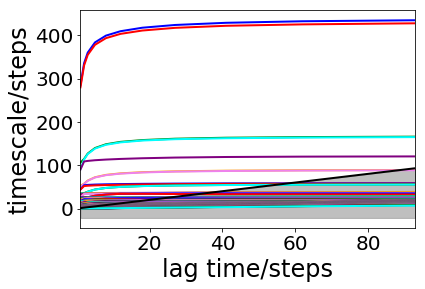

In [9]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
#plt.xlim(0,100)
#plt.ylim(100,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [10]:
# Choose lag time and obtain MSM "M" for our milestones
msm_lag = 10
M = pyemma.msm.estimate_markov_model(dTrajs, msm_lag, reversible=True)

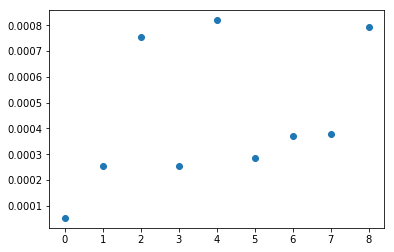

In [13]:
# Plot transition probabilities to bath state
T = M.transition_matrix
plt.plot(np.sum(T[:9,-48:],axis=1), 'o')

In [18]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, parameters):
        self.tmatrix = tmatrix
        self.centers= centers
        self.parameters = parameters
parameters = {}
parameters['interactionRadius'] = discretizer.innerMSMrad
parameters['entryRadius'] = discretizer.entryRad
parameters['bathRadius'] = discretizer.bathRad
parameters['outerBathRadius'] = discretizer.bathRadOut
parameters['NCenters'] = discretizer.Ncenters
parameters['NangularPartitions'] = discretizer.angularPartitions
parameters['entryRings'] = discretizer.entryRings
parameters['exitRings'] = discretizer.exitRings
parameters['lagtime'] = msm_lag
model = MSMmodel(T, minima, parameters)

In [19]:
import pickle
pickle.dump(model, open('../data/models/asym2D/10radial48angular10lag.p', 'wa'))